# Computación Científica 2 - Tarea 1
---
Vicente Lizana Estivill  
vlizana@alumnos.inf.utfsm.cl  
201310004-K

---

## Introducción
---



En esta tarea profundizaremos en los valores y vectores propios, como se comportan en diferentes tipos de matrices y como actúan sobre ellas los métodos numéricos de mayor relevancia para este curso. Trabajaremos también con matrices complejas y visualizaremos los valores propios y sus acotaciones mediante los discos de Gerschgorin en el plano complejo.

---

## Desarrollo y Análisis de Resultados
---

### Bibliotecas
---

In [88]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from random import choice

---

### Generación Aleatoria de Matrices
---

En primer lugar creamos los procedimientos para generar aleatoriamente las matrices necesarias.

#### Matriz Sparse:

Creamos una matriz vacía y rellenamos máximo el 20% con valores aleatorios, si resulta ser singular repetimos el procedimiento.

In [89]:
def get_sparse(m_size):
    A = np.zeros((2, 2))
    while la.det(A) == 0:
        A = np.zeros((m_size, m_size), dtype=complex)
        for _ in range((m_size**2)//5):
            i, j = np.random.randint(m_size, size=2)
            A[i, j] = np.random.uniform(low=-1)
            A[i, j] += 1j*np.random.uniform(low=-1)
    return A

#### Matriz Triangular Superior y Unitaria:

Aprovechamos las propiedades de la factorización **QR**. Generando una matriz aleatoria y factorizando obtenemos una matriz unitaria (**Q**) y una triangular superior (**R**).

In [90]:
def get_unit_and_upper(m_size):
    A = 2 * np.random.rand(m_size, m_size) - 1
    B = 2 * np.random.rand(m_size, m_size) - 1
    return la.qr(A + 1j*B)

def get_unit(m_size):
    return get_unit_and_upper(m_size)[0]

def get_upper(m_size):
    return get_unit_and_upper(m_size)[1]

#### Matriz Diagonal Dominante:

Generamos una matriz aleatoria y a cada elemento de la diagonal le sumamos el valor absoluto de cada elemento de la fila, incluyendo el mismo valor. De esta manera, en el peor de los casos este valor será igual que la suma absoluta del resto de la fila.

In [91]:
def get_DD(m_size):
    A = 2 * np.random.rand(m_size, m_size) - 1
    A += np.diag(np.add.reduce(np.absolute(A), axis=1))
    B = 2 * np.random.rand(m_size, m_size) - 1
    B += np.diag(np.add.reduce(np.absolute(B), axis=1))
    return A + 1j*B

---

### Utilidades

Funciones que nos serán útiles más adelante.

In [92]:
# sorting values by magnitude.
def abs_sort(arr, direction=-1):
    positives = np.abs(arr)
    idx = positives.argsort()[::direction]
    return arr[idx]

In [93]:
# sorted eigenvalues for comparison.
def sorted_eigens(A, n=None, d=-1):
    eigens = la.eigvals(A)
    return abs_sort(eigens, d)[:n]

In [94]:
# for printing eigens.
def print_eigens(approx, real):
    print("  Approximations:", " "*25, "Real Values:")
    for val1, val2 in zip(approx, real):
        print("{:>15.11f}".format(np.real(val1)), "+", "{:>15.11f}".format(np.imag(val1)), "i", end="       ")
        print("{:>15.11f}".format(np.real(val2)), "+", "{:>15.11f}".format(np.imag(val2)), "i")

In [130]:
# Discos de Gerschgorin
# =====================
# Parametros de entrada
# A: matriz cuadrada de n x n
# eigfun: funcion que obtiene valores propios de A

def gerschgorin(A, eigfun=la.eigvals, show=True, first=None, inv=False):
    #valores propios de la matriz A ingresada como parametro
    if not first:
        eigs = eigfun(A)
    elif eigfun==la.eigvals:
        if not inv:
            eigs = abs_sort(eigfun(A))[:first]
        else:
            eigs = abs_sort(eigfun(A), direction=1)[:first]
    else:
        if not inv:
            eigs = eigfun(A, n=first)
        else:
            eigs = eigfun(A, n=first, d=1)
    filas, columnas = A.shape
    
    #solo se adminten matrices cuadradas
    if filas != columnas:
        return
    
    #se muestran los valores propios de la matriz A
    if show:
        print("Valores Propios")
        for val in eigs:
            print("{:>15.11f}".format(np.real(val)), "+", "{:>15.11f}".format(np.imag(val)), "i")
    
    #calculo de los discos de gerschgorin
    for i in range(len(eigs)):
        #calculo de un disco por fila de la matriz
        radio = 0
        centro = 0
        for j in range(columnas):
            if i != j:
                radio += abs(A[i][j])
            else:
                centro = A[i][i]
        
        theta = np.linspace(0, 2*np.pi, 100)
        x = radio*np.sin(theta) + np.real(centro)
        y = radio*np.cos(theta) + np.imag(centro)
        plt.plot(x, y)
        
    for e in eigs:
        plt.plot(np.real(e), np.imag(e), 'db')
    plt.xlabel("Re($\lambda$)")
    plt.ylabel("Im($\lambda$)")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

---

### Desarrollo

Primero generamos las matrices

In [96]:
A_sparse = get_sparse(100)
A_unit, A_upper = get_unit_and_upper(100)
A_DD = get_DD(100)

---
#### Pregunta 1

Obtenga los primeros 10 valores propios dominantes, utilizando métodos numéricos apropiados. Reporte los valores obtenidos y muéstrelos gráficamente utilizando los Discos de Gerschgorin. ¿Qué puede decir acerca de los valores y gráficos obtenidos?

---

Primero debemos seleccionar el método. Power iteration no nos sirve ya que solo entrega el valor propio dominante y posteriormente tendríamos que encontrar _initial guesses_ ortogonales a los vectores propios ya encontrados, lo que resulta bastante engorroso.

Utilizaremos _Unshifted QR_, ya que nos entrega todos los valores propios mediante la ortogonalización constante de la base.

In [97]:
# From the book Numerical Analysis, Timothy Sauer
def unshifted_QR(A, n=None, iters=100, d=-1):
    Q = np.eye(A.shape[0])
    Qbar = np.eye(A.shape[0])
    R = A
    for _ in range(iters):
        Q, R = la.qr(R @ Q)
        Qbar = Qbar @ Q
    eigenvs = np.diag(R @ Q)
    return abs_sort(eigenvs, direction=d)[:n]

---
**Sparse**

In [98]:
sparse_eigens_app = unshifted_QR(A_sparse, n=10)
sparse_eigens = sorted_eigens(A_sparse, n=10)
print("Sparse Matrix Eigenvalues")
print_eigens(sparse_eigens_app, sparse_eigens)

Sparse Matrix Eigenvalues
  Approximations:                           Real Values:
 -1.92456305045 +   3.13237348846 i        -2.01918130508 +   3.14078830809 i
  2.60308541731 +   2.16628073282 i         3.67279624666 +  -0.20515783104 i
  3.27515271024 +   0.49731917967 i         2.29464588019 +   2.86769891150 i
 -0.98440176925 +  -2.89637579348 i        -1.45343193518 +   3.21769625076 i
 -1.22076047667 +  -2.80045368592 i         1.58555459619 +  -3.12833589125 i
  0.26551956533 +  -2.76114532517 i        -3.44040967411 +   0.64896685833 i
  2.62662134706 +   0.80768362993 i         3.34169215709 +  -0.99366076191 i
 -2.26328887846 +   1.08823350487 i        -0.54008629166 +   3.39983931576 i
 -0.16481408801 +   2.36852076659 i        -3.20919248730 +  -0.96942109043 i
 -1.39039357232 +   1.87650149495 i         3.25690820808 +   0.75569042633 i


Approximation


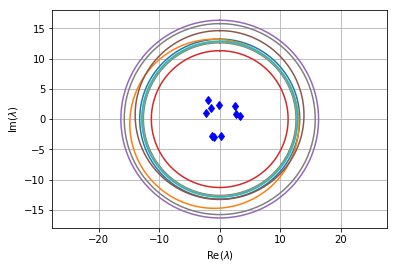

Real


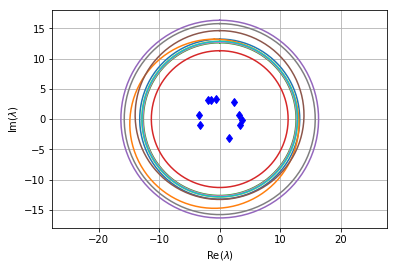

In [99]:
print("Approximation")
gerschgorin(A_sparse, eigfun=unshifted_QR, first=10, show=False)
print("Real")
gerschgorin(A_sparse, first=10, show=False)

Podemos ver que el método no es muy preciso con matrices sparse, ya que los módulos de los _eigenvalues_ dominantes son bastante cercanos entre sí.

---

**Upper Triangular**

In [100]:
upper_eigens_app = unshifted_QR(A_upper, n=10)
upper_eigens = sorted_eigens(A_upper, n=10)
print("Upper Triangular Matrix Eigenvalues")
print_eigens(upper_eigens_app, upper_eigens)

Upper Triangular Matrix Eigenvalues
  Approximations:                           Real Values:
 -8.14812121630 +   0.00000000000 i        -8.14812121630 +   0.00000000000 i
 -8.03589163753 +   0.00000000000 i        -8.03589163753 +   0.00000000000 i
 -7.92854623064 +   0.00000000000 i        -7.92854623064 +   0.00000000000 i
  7.90504022566 +   0.00000000000 i         7.90504022566 +   0.00000000000 i
  7.90330551653 +   0.00000000000 i         7.90330551653 +   0.00000000000 i
  7.85313023304 +   0.00000000000 i         7.85313023304 +   0.00000000000 i
 -7.85300332199 +   0.00000000000 i        -7.85300332199 +   0.00000000000 i
  7.82324025865 +   0.00000000000 i         7.82324025865 +   0.00000000000 i
 -7.80203913174 +   0.00000000000 i        -7.80203913174 +   0.00000000000 i
 -7.72584217854 +   0.00000000000 i        -7.72584217854 +   0.00000000000 i


Approximation


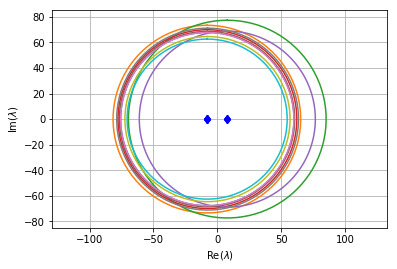

Real


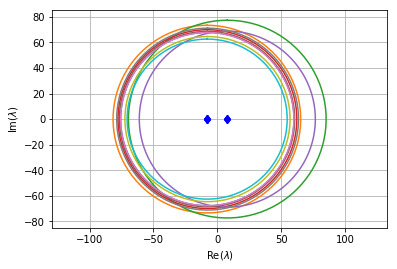

In [101]:
print("Approximation")
gerschgorin(A_upper, eigfun=unshifted_QR, first=10, show=False)
print("Real")
gerschgorin(A_upper, first=10, show=False)

En este caso tenemos aproximaciones mucho mejores ya que las matrices triangulares superiores tienen _eigenvalues_ reales y aparte los valores se diferencian más entre ellos.

---

** Unitary **

In [102]:
unit_eigens_app = unshifted_QR(A_unit, n=10)
unit_eigens = sorted_eigens(A_unit, n=10)
print("Unitary Matrix Eigenvalues")
print_eigens(unit_eigens_app, unit_eigens)

Unitary Matrix Eigenvalues
  Approximations:                           Real Values:
 -0.12905563272 +  -0.11032411624 i        -0.29374513222 +   0.95588377813 i
 -0.09665548333 +   0.13131842691 i         0.97519272146 +   0.22135752981 i
 -0.09397594989 +  -0.12622268834 i         0.16939893281 +  -0.98554756433 i
 -0.15305271672 +  -0.03071412853 i        -0.85293394146 +  -0.52201886125 i
  0.01709393049 +   0.15451229080 i         0.73303079455 +  -0.68019545297 i
 -0.13523649095 +  -0.05487865863 i         0.65826427337 +   0.75278691965 i
 -0.03227886908 +   0.13539503308 i         0.10818161481 +  -0.99413114739 i
 -0.10093366732 +   0.09404239211 i         0.49760016514 +   0.86740652271 i
 -0.13269639070 +   0.03096786282 i        -0.41170656263 +  -0.91131646879 i
 -0.05596868513 +   0.12265278206 i        -0.28075440461 +  -0.95977964361 i


Approximation


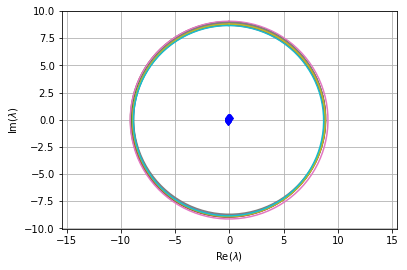

Real


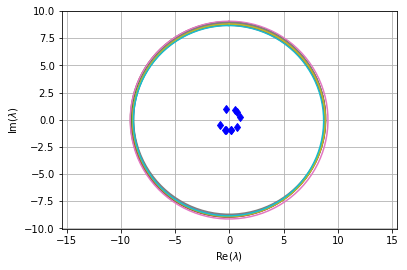

In [103]:
print("Approximation")
gerschgorin(A_unit, eigfun=unshifted_QR, first=10, show=False)
print("Real")
gerschgorin(A_unit, first=10, show=False)

Las aproximaciones son muy malas, ya que por definición los _eigenvalues_ de una matriz unitaria deberían tener todos módulo 1, y por tanto ser todos dominantes.

---

** Diagonally Dominant **

In [104]:
DD_eigens_app = unshifted_QR(A_DD, n=10)
DD_eigens = sorted_eigens(A_DD, n=10)
print("Diagonally Dominant Matrix Eigenvalues")
print_eigens(DD_eigens_app, DD_eigens)

Diagonally Dominant Matrix Eigenvalues
  Approximations:                           Real Values:
 55.75210240225 +  56.11704422445 i        54.79456120719 +  57.29785477317 i
 53.41940565200 +  58.18312576020 i        52.77767386079 +  59.02504874649 i
 56.23993460843 +  55.16074680486 i        56.84902911865 +  54.78400458808 i
 57.79616331233 +  53.38930090672 i        59.28525403566 +  51.66965992429 i
 57.45337309416 +  53.74272811055 i        56.89206824587 +  53.65486378000 i
 56.20396686049 +  54.06574990094 i        59.26242271107 +  50.89838349972 i
 56.63590118863 +  53.05174132922 i        52.99329410057 +  57.20162448383 i
 54.65470586435 +  55.00255614673 i        59.60122178742 +  50.03771478386 i
 56.51703727272 +  52.82543791029 i        54.56258658057 +  54.87099069284 i
 55.81193800531 +  53.51034418416 i        56.12766208422 +  53.26316151298 i


Approximation


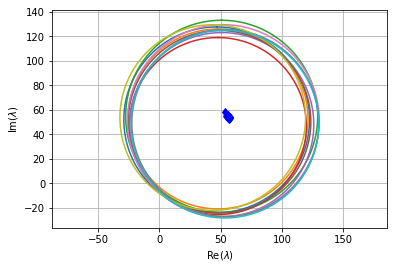

Real


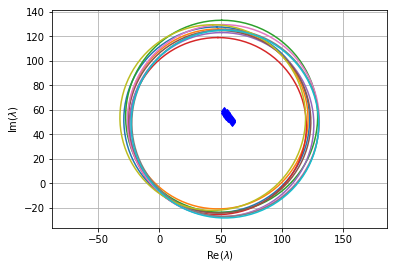

In [105]:
print("Approximation")
gerschgorin(A_DD, eigfun=unshifted_QR, first=10, show=False)
print("Real")
gerschgorin(A_DD, first=10, show=False)

Las aproximaciones resultan aceptables hasta cierto punto.

---
### Pregunta 2

Obtenga 10 Ritz Values de mayor magnitud utilizando un método numérico apropiado. Compáre estos valores con los primeros 10 valores propios dominantes de la matriz $A$, ordenados descendentemente en magnitud. Compare los Ritz Values con los valores propios mediante un gráfico. ¿Son los Ritz Values una buena estimación de los valores propio dominantes de la pregunta anterior? ¿Podría obtener una mejor estimación para los 10 valores propios dominantes?

---

Este método se basa en la semejanza entre una matriz _A_ y su matriz de Hessenberg, al tener los mismos _eigenvalues_ es más barato computar los de _H_ debido a su forma. 

In [121]:
def ritz_values(A, n=None, iters=100, d=-1):
    H = la.hessenberg(A)
    ritz = unshifted_QR(H, iters)
    return abs_sort(ritz, direction=d)[:n]

---
** Sparse **

In [107]:
sparse_eigens_app_rv = ritz_values(A_sparse, n=10)
print("Sparse Matrix Eigenvalues")
print_eigens(sparse_eigens_app_rv, sparse_eigens)

Sparse Matrix Eigenvalues
  Approximations:                           Real Values:
 -1.92456305045 +   3.13237348846 i        -2.01918130508 +   3.14078830809 i
  3.11777173596 +   1.06595215514 i         3.67279624666 +  -0.20515783104 i
  2.77781204199 +   1.59096097767 i         2.29464588019 +   2.86769891150 i
 -1.96697720655 +   2.28852410059 i        -1.45343193518 +   3.21769625076 i
 -1.10419466289 +   2.74415255782 i         1.58555459619 +  -3.12833589125 i
  2.87815579665 +  -0.62086294411 i        -3.44040967411 +   0.64896685833 i
 -1.11744025983 +  -2.67812224522 i         3.34169215709 +  -0.99366076191 i
 -1.62454280251 +   2.34852384660 i        -0.54008629166 +   3.39983931576 i
 -0.43700140433 +  -2.65975972078 i        -3.20919248730 +  -0.96942109043 i
  2.39951121248 +   1.05401616756 i         3.25690820808 +   0.75569042633 i


Approximation


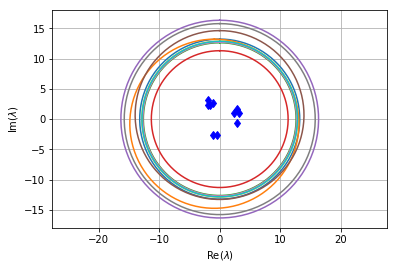

Real


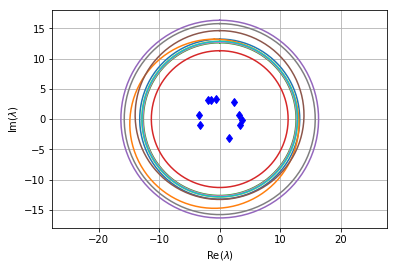

In [108]:
print("Approximation")
gerschgorin(A_sparse, eigfun=ritz_values, first=10, show=False)
print("Real")
gerschgorin(A_sparse, first=10, show=False)

---
** Upper Triangular **

In [109]:
upper_eigens_app_rv = ritz_values(A_upper, n=10)
print("Upper Triangular Matrix Eigenvalues")
print_eigens(upper_eigens_app_rv, upper_eigens)

Upper Triangular Matrix Eigenvalues
  Approximations:                           Real Values:
 -8.14812121630 +   0.00000000000 i        -8.14812121630 +   0.00000000000 i
 -8.03589163753 +   0.00000000000 i        -8.03589163753 +   0.00000000000 i
 -7.92854623064 +   0.00000000000 i        -7.92854623064 +   0.00000000000 i
  7.90504022566 +   0.00000000000 i         7.90504022566 +   0.00000000000 i
  7.90330551653 +   0.00000000000 i         7.90330551653 +   0.00000000000 i
  7.85313023304 +   0.00000000000 i         7.85313023304 +   0.00000000000 i
 -7.85300332199 +   0.00000000000 i        -7.85300332199 +   0.00000000000 i
  7.82324025865 +   0.00000000000 i         7.82324025865 +   0.00000000000 i
 -7.80203913174 +   0.00000000000 i        -7.80203913174 +   0.00000000000 i
 -7.72584217854 +   0.00000000000 i        -7.72584217854 +   0.00000000000 i


Approximation


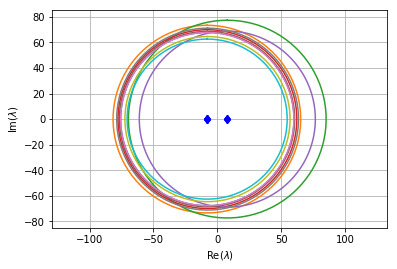

Real


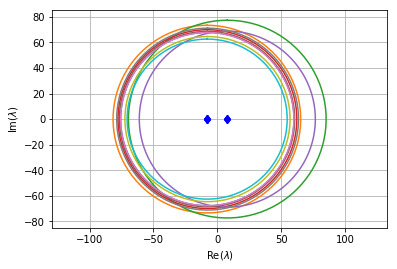

In [110]:
print("Approximation")
gerschgorin(A_upper, eigfun=ritz_values, first=10, show=False)
print("Real")
gerschgorin(A_upper, first=10, show=False)

---
** Unitary **

In [111]:
unit_eigens_app_rv = ritz_values(A_unit, n=10)
print("Unitary Matrix Eigenvalues")
print_eigens(unit_eigens_app_rv, unit_eigens)

Unitary Matrix Eigenvalues
  Approximations:                           Real Values:
 -0.92520278489 +   0.32188003701 i        -0.29374513222 +   0.95588377813 i
 -0.50575438196 +   0.17493517907 i         0.97519272146 +   0.22135752981 i
 -0.49928135965 +  -0.03865203181 i         0.16939893281 +  -0.98554756433 i
 -0.25374145646 +   0.36924884027 i        -0.85293394146 +  -0.52201886125 i
  0.20233307903 +  -0.17173034766 i         0.73303079455 +  -0.68019545297 i
 -0.04832902496 +   0.23166789733 i         0.65826427337 +   0.75278691965 i
 -0.03826443832 +  -0.21159386762 i         0.10818161481 +  -0.99413114739 i
 -0.17651907303 +   0.02451972750 i         0.49760016514 +   0.86740652271 i
 -0.06471571840 +   0.13544037597 i        -0.41170656263 +  -0.91131646879 i
 -0.13817787700 +  -0.00995638854 i        -0.28075440461 +  -0.95977964361 i


Approximation


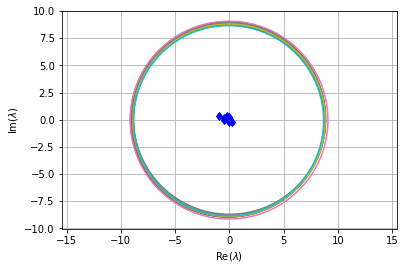

Real


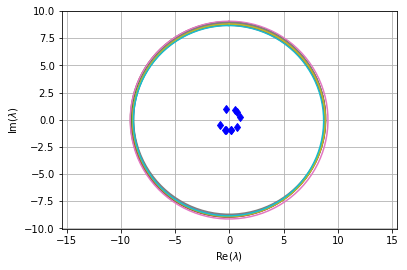

In [112]:
print("Approximation")
gerschgorin(A_unit, eigfun=ritz_values, first=10, show=False)
print("Real")
gerschgorin(A_unit, first=10, show=False)

---

** Diagonally Dominant **

In [113]:
DD_eigens_app_rv = ritz_values(A_DD, n=10)
print("Diagonally Dominant Matrix Eigenvalues")
print_eigens(DD_eigens_app_rv, DD_eigens)

Diagonally Dominant Matrix Eigenvalues
  Approximations:                           Real Values:
 55.08522119375 +  57.40662460073 i        54.79456120719 +  57.29785477317 i
 55.75210240225 +  56.11704422445 i        52.77767386079 +  59.02504874649 i
 55.02204995251 +  56.25406575475 i        56.84902911865 +  54.78400458808 i
 57.80040603172 +  53.35728539856 i        59.28525403566 +  51.66965992429 i
 56.23627185457 +  53.51891168896 i        56.89206824587 +  53.65486378000 i
 53.52265378008 +  55.16543014419 i        59.26242271107 +  50.89838349972 i
 53.02018817515 +  54.55994880222 i        52.99329410057 +  57.20162448383 i
 54.83813176694 +  52.18876191207 i        59.60122178742 +  50.03771478386 i
 54.89594116421 +  51.98869765127 i        54.56258658057 +  54.87099069284 i
 52.88904461218 +  53.02953454456 i        56.12766208422 +  53.26316151298 i


Approximation


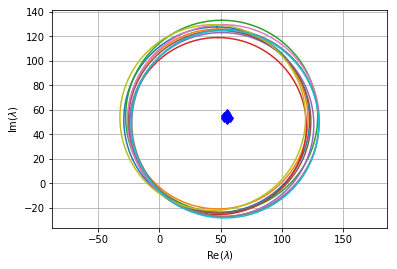

Real


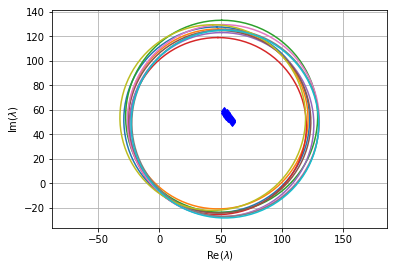

In [114]:
print("Approximation")
gerschgorin(A_DD, eigfun=ritz_values, first=10, show=False)
print("Real")
gerschgorin(A_DD, first=10, show=False)

---
A simple vista tenemos un comportamiento bastante similar a _unshifted QR_. A continuación se grafican las proximaciones.

In [ ]:
x = np.arange(1, 11, dtype='int')

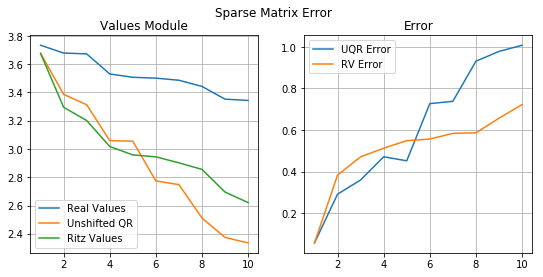

In [152]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle("Sparse Matrix Error")

ax1 = fig.add_subplot(121)
ax1.set_title("Values Module")
ax1.plot(x, np.abs(sparse_eigens), label="Real Values")
ax1.plot(x, np.abs(sparse_eigens_app), label="Unshifted QR")
ax1.plot(x, np.abs(sparse_eigens_app_rv), label="Ritz Values")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_title("Error")
ax2.plot(x, np.abs(sparse_eigens)-np.abs(sparse_eigens_app), label="UQR Error")
ax2.plot(x, np.abs(sparse_eigens)-np.abs(sparse_eigens_app_rv), label="RV Error")
ax2.grid()
ax2.legend()

plt.show()

Podemos ver que se comportan de manera similar.

---

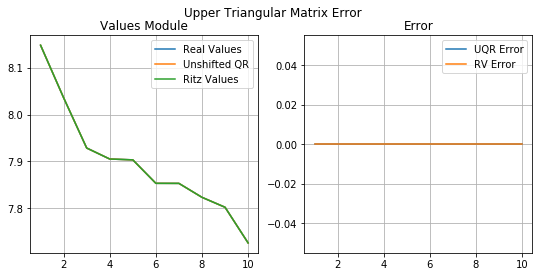

In [153]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle("Upper Triangular Matrix Error")

ax1 = fig.add_subplot(121)
ax1.set_title("Values Module")
ax1.plot(x, np.abs(upper_eigens), label="Real Values")
ax1.plot(x, np.abs(upper_eigens_app), label="Unshifted QR")
ax1.plot(x, np.abs(upper_eigens_app_rv), label="Ritz Values")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_title("Error")
ax2.plot(x, np.abs(upper_eigens)-np.abs(upper_eigens_app), label="UQR Error")
ax2.plot(x, np.abs(upper_eigens)-np.abs(upper_eigens_app_rv), label="RV Error")
ax2.grid()
ax2.legend()

plt.show()

Como mencionamos antes, en estas matrices el error es muy bajo cuando existe debido a su naturaleza.

---

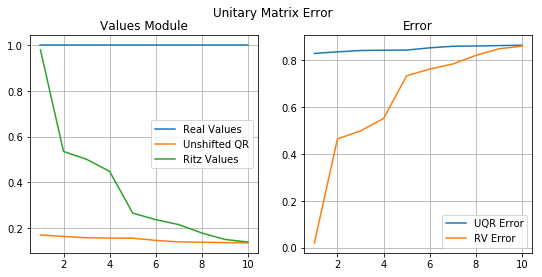

In [154]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle("Unitary Matrix Error")

ax1 = fig.add_subplot(121)
ax1.set_title("Values Module")
ax1.plot(x, np.abs(unit_eigens), label="Real Values")
ax1.plot(x, np.abs(unit_eigens_app), label="Unshifted QR")
ax1.plot(x, np.abs(unit_eigens_app_rv), label="Ritz Values")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_title("Error")
ax2.plot(x, np.abs(unit_eigens)-np.abs(unit_eigens_app), label="UQR Error")
ax2.plot(x, np.abs(unit_eigens)-np.abs(unit_eigens_app_rv), label="RV Error")
ax2.grid()
ax2.legend()

plt.show()

El error aca es relativamente menor utilizando Ritz Values. Sin embargo, ámbas aproximaciones resultan poco precisas.

---

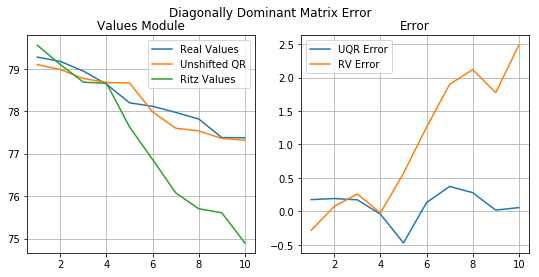

In [155]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle("Diagonally Dominant Matrix Error")

ax1 = fig.add_subplot(121)
ax1.set_title("Values Module")
ax1.plot(x, np.abs(DD_eigens), label="Real Values")
ax1.plot(x, np.abs(DD_eigens_app), label="Unshifted QR")
ax1.plot(x, np.abs(DD_eigens_app_rv), label="Ritz Values")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_title("Error")
ax2.plot(x, np.abs(DD_eigens)-np.abs(DD_eigens_app), label="UQR Error")
ax2.plot(x, np.abs(DD_eigens)-np.abs(DD_eigens_app_rv), label="RV Error")
ax2.grid()
ax2.legend()

plt.show()

Nuevamente no se ven grandes fluctuaciones en el comportamiento de ámbos métodos.

---
Pareciera que se puede lograr una mejor aproximación, ya que en muchas ocasiones el error relativo es demasiado alto. Probablemente en la mayor parte de los casos resulte mejor pagar el precio de calcular los valores exactos.

---
### Pregunta 3

Obtenga los 10 valores propios de menor magnitud, usando los Ritz Values. ¿Son estos valores los esperados? Comente.

---

** Sparse **

In [131]:
sparse_eigens_app_rv_low = ritz_values(A_sparse, n=10, d=1)
sparse_eigens_low = sorted_eigens(A_sparse, n=10, d=1)
print("Sparse Matrix Lower Eigenvalues")
print_eigens(sparse_eigens_app_rv_low, sparse_eigens_low)

Sparse Matrix Lower Eigenvalues
  Approximations:                           Real Values:
 -0.10489069091 +   0.07604868900 i         0.38573448600 +  -0.02667722329 i
 -0.15843258239 +   0.01251446521 i        -0.55415477026 +  -0.10297953509 i
  0.38573448600 +  -0.02667722329 i         0.25457229057 +  -0.51456395752 i
  0.23780119589 +  -0.30877665365 i         0.60080279654 +   0.13223360525 i
 -0.25193425110 +   0.30532207508 i         0.47887811703 +   0.62792926595 i
 -0.22540953194 +   0.37811395266 i        -0.69271773402 +   0.42317736021 i
  0.48923377610 +   0.05741021704 i        -0.16827074397 +   0.86401846339 i
 -0.54612297600 +  -0.11174132786 i        -0.52904832658 +  -0.79213208733 i
  0.24655883425 +  -0.50580526867 i        -0.62928430977 +   0.73132008276 i
  0.03892148581 +   0.56463858384 i         0.60357210999 +   0.90489922914 i


Approximation


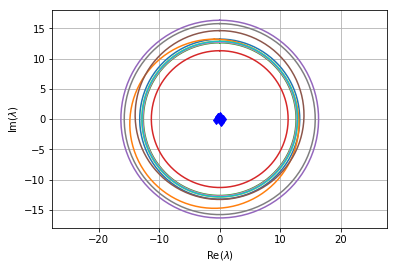

Real


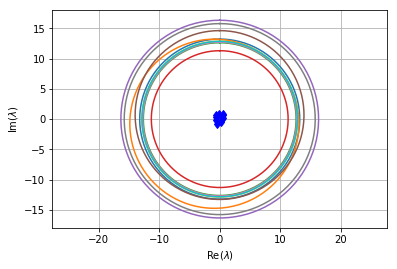

In [132]:
print("Approximation")
gerschgorin(A_sparse, eigfun=ritz_values, first=10, show=False, inv=True)
print("Real")
gerschgorin(A_sparse, first=10, show=False, inv=True)

---
** Upper Triangular **

In [133]:
upper_eigens_app_rv_low = ritz_values(A_upper, n=10, d=1)
upper_eigens_low = sorted_eigens(A_upper, n=10, d=1)
print("Upper Triangular Matrix Lower Eigenvalues")
print_eigens(upper_eigens_app_rv_low, upper_eigens_low)

Upper Triangular Matrix Lower Eigenvalues
  Approximations:                           Real Values:
  0.46215228511 +   0.00000000000 i         0.46215228511 +   0.00000000000 i
  1.19629102424 +   0.00000000000 i         1.19629102424 +   0.00000000000 i
 -1.87691867948 +   0.00000000000 i        -1.87691867948 +   0.00000000000 i
 -2.12638987035 +   0.00000000000 i        -2.12638987035 +   0.00000000000 i
  2.14750083548 +   0.00000000000 i         2.14750083548 +   0.00000000000 i
 -2.21987666114 +   0.00000000000 i        -2.21987666114 +   0.00000000000 i
  2.34380350488 +   0.00000000000 i         2.34380350488 +   0.00000000000 i
 -2.37231256184 +   0.00000000000 i        -2.37231256184 +   0.00000000000 i
 -2.51300531539 +   0.00000000000 i        -2.51300531539 +   0.00000000000 i
  2.58025944531 +   0.00000000000 i         2.58025944531 +   0.00000000000 i


Approximation


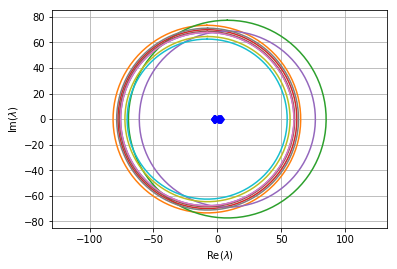

Real


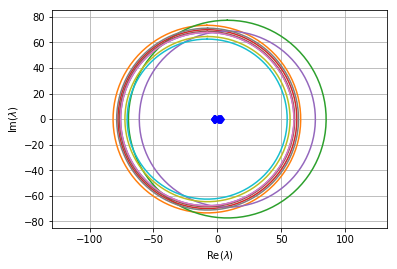

In [134]:
print("Approximation")
gerschgorin(A_upper, eigfun=ritz_values, first=10, show=False, inv=True)
print("Real")
gerschgorin(A_upper, first=10, show=False, inv=True)

---
** Unitary **

In [135]:
unit_eigens_app_rv_low = ritz_values(A_unit, n=10, d=1)
unit_eigens_low = sorted_eigens(A_unit, n=10, d=1)
print("Unitary Matrix Lower Eigenvalues")
print_eigens(unit_eigens_app_rv_low, unit_eigens_low)

Unitary Matrix Lower Eigenvalues
  Approximations:                           Real Values:
  0.00067420065 +   0.00059647057 i        -0.19899807132 +   0.97999988143 i
 -0.00097956125 +  -0.00077559308 i        -0.49116387767 +   0.87106718758 i
  0.00128195544 +   0.00058197581 i         0.77026876733 +   0.63771939446 i
 -0.00005054449 +  -0.00152633503 i         0.52218618824 +  -0.85283151021 i
 -0.00072705040 +   0.00147257562 i        -0.99973221492 +  -0.02314083931 i
  0.00118584205 +  -0.00116523527 i        -0.99413340995 +   0.10816082106 i
  0.00027861024 +  -0.00170169732 i        -0.51907874197 +  -0.85472642385 i
 -0.00205379998 +   0.00091541680 i         0.34611334489 +   0.93819270541 i
 -0.00217320665 +  -0.00124577545 i        -0.69007467818 +   0.72373816987 i
 -0.00051160451 +  -0.00275282855 i        -0.96749450524 +   0.25289203690 i


Approximation


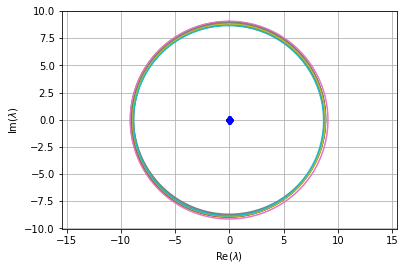

Real


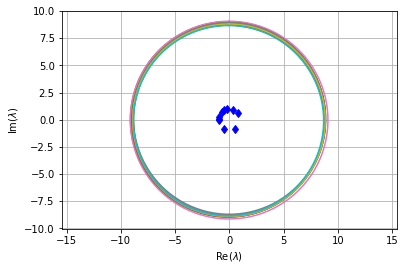

In [136]:
print("Approximation")
gerschgorin(A_unit, eigfun=ritz_values, first=10, show=False, inv=True)
print("Real")
gerschgorin(A_unit, first=10, show=False, inv=True)

---
** Diagonally Dominant **

In [137]:
DD_eigens_app_rv_low = ritz_values(A_DD, n=10, d=1)
DD_eigens_low = sorted_eigens(A_DD, n=10, d=1)
print("Diagonally Dominant Matrix Lower Eigenvalues")
print_eigens(DD_eigens_app_rv_low, DD_eigens_low)

Diagonally Dominant Matrix Lower Eigenvalues
  Approximations:                           Real Values:
 49.04524649606 +  47.60136982617 i        44.85368013596 +  41.16723113498 i
 48.35101100244 +  48.33364412877 i        46.69274807407 +  39.98471724522 i
 48.43429243768 +  48.27817865686 i        43.56924518249 +  43.74477511526 i
 49.05561765608 +  47.83069168914 i        44.87857394669 +  44.09572980410 i
 48.89198421902 +  48.11984619823 i        46.21685080822 +  43.70339796457 i
 48.44600634690 +  48.58059013192 i        47.48709292520 +  42.37821544004 i
 49.39959591713 +  47.92260557244 i        42.89548408676 +  47.18947175076 i
 49.06134571988 +  48.43415184358 i        44.32164108713 +  46.01653429516 i
 50.11600158449 +  47.34390737662 i        40.82637390982 +  49.50709210976 i
 48.16112369226 +  49.41326151864 i        49.52337626985 +  41.06041553866 i


Approximation


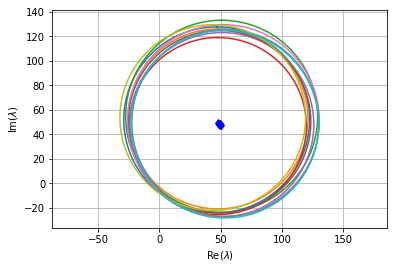

Real


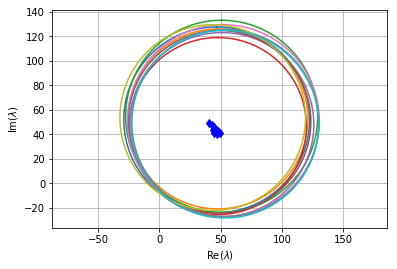

In [138]:
print("Approximation")
gerschgorin(A_DD, eigfun=ritz_values, first=10, show=False, inv=True)
print("Real")
gerschgorin(A_DD, first=10, show=False, inv=True)

---
En general no se aprecian grandes diferencias entre el error relativo de calcular los menores _eigenvalues_ y el de calcular los dominantes, por lo que los valores son los esperados.

## Conclusiones
---

* Al iniciar los experimentos para el desarrollo de esta tarea se utilizó _Power Iteration_ y se pudo ver que era un buen método para aproximar el _eigenvalue_ dominante, sin embargo, los métodos utilizados en la versión final en lo personal dejaron bastante que desear. Existen casos particulares en donde actúan bien pero el error resulta ser bastante amplio, independiente de algunos factores que no se mencionaron en la versión final tales como el número de iteraciones.
* Si Ritz Values entregara los _eigenvalues_ en orden podríamos utilizar una versión parcial de la matriz de Hessenberg, terminando la iteración de _Arnoldi_ en el tamaño deseado (por ejemplo dejarla de tamaño 10 para obtener aproximaciones de los 10 _eigenvalues_ dominantes), sin embargo luego de un par de experimentos se notó que este no era el caso.

## Referencias
---

[Documentación de Matplotlib](https://matplotlib.org/api/pyplot_api.html)    
[Documentación de SciPy](https://docs.scipy.org/doc/scipy/reference/)